15-2. 데이터 수집 및 Visualization
의료영상의 특징을 살펴보기 위해 오늘 우리가 다룰 위내시경 용종 데이터셋을 전처리하고 시각화하는 과정을 먼저 진행해 보겠습니다.

아래와 같이 주요 라이브러리를 로딩해 줍니다.

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


데이터 준비
오늘의 프로젝트는 Giana Dataset에서 제공하는 용종 내시경 데이터셋을 이용하여 진행할 것입니다.

오늘 우리가 사용할 영상의 그랜드챌린지 기간이 지났다면 데이터 다운로드가 원활하지 않을 수 있습니다. 그래서 아래 코드를 통해 데이터를 준비해 줍니다.

In [2]:
!mkdir -p ~/aiffel/medical1
!ln -s ~/data/* ~/aiffel/medical1

ln: failed to create symbolic link '/aiffel/aiffel/medical1/ed_ckpt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical1/train': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical1/train_labels': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical1/unet_ckpt': File exists


Split dataset into train data and test data
위에서 다운로드한 데이터셋을 학습용과 테스트용으로 분리하겠습니다. 데이터셋의 이미지와 라벨은 각각 train, train_labels 디렉토리에 분리되어 있고, 쌍을 이루는 이미지와 라벨의 파일명은 동일합니다. 그리고 사이킷런의 train_test_split을 이용해서 학습(train) 데이터와 테스트(test) 데이터를 분리할 것입니다.

In [3]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical1')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [4]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [5]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [6]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


잘 로딩되었나요? 생각보다 이미지 갯수가 많지 않습니다. 우려가 되지 않으시나요? 과연 이 정도 갯수의 데이터로 모델이 정상적으로 훈련될 수 있을까요? 그러나 의료영상 처리 분야는 언제든 이렇게 데이터 갯수 부족 문제에 시달려야 할 때가 많을 것입니다.

Visualization
데이터 셋에서 이미지 샘플을 5개 정도 살펴봅시다.

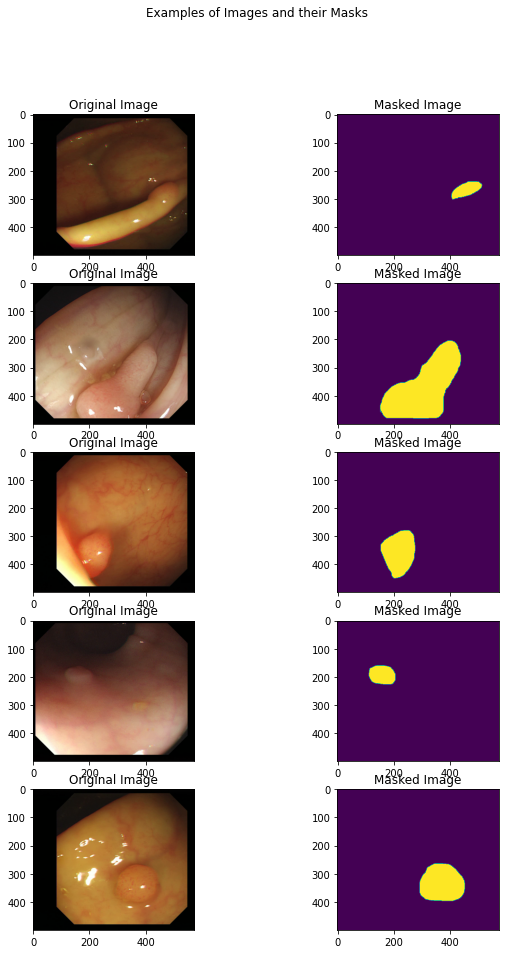

In [7]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

보시는 것처럼 라벨은 클래스 값이 아니라, 입력이미지와 동일한 X-Y 사이즈를 가지고 용종 부위만 표시된 1채널짜리 이미지입니다. 즉, 우리가 오늘 도전할 태스크는 Image classification이 아니라 Semantic Segmentation이 됩니다.

15-3. Data pipeline and Preprocessing
Set up hyper-parameters
공통적으로 적용될 하이퍼파라미터를 미리 셋팅해 두겠습니다.

In [8]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

tf.data를 활용한 입력 파이프라인 설계
오늘 우리는 tf.data.Dataset을 이용해 데이터셋 구축, 배치처리 등을 진행할 것입니다. 이 과정에서 다양한 함수를 map에 적용하여 Data Augmentation을 함께 구현할 것입니다.

다음과 같은 과정으로 진행하겠습니다. 이 과정은 tf.data에 대한 텐서플로우 튜토리얼에 소개된 내용을 정리한 것입니다.

이미지와 레이블 모두 파일 이름에서 파일의 바이트(컴퓨터는 모든 데이터를 0과 1로 이루어진 비트(bit)의 조합으로 표현합니다. 8개의 비트가 모여 1바이트(byte)를 구성하며, 바이트는 컴퓨터가 데이터를 저장하고 처리하는 기본적인 단위)를 읽습니다. 라벨은 실제로 각 픽셀이 용종데이터로 (1, 0)으로 주석이 달린 이미지입니다.
바이트를 이미지 형식으로 디코딩(바이트들을 이미지 형식에 맞게 해석하여 픽셀 값, 색상 정보 등으로 변환해야 합니다.)합니다.
_augment 함수를 통한 이미지 변환 적용 : (optional, input parameters에 따라서)
resize-이미지를 표준 크기로 조정합니다 (eda 또는 계산 / 메모리 제한에 의해 결정됨)
resize의 이유는 U-Net이 fully convolution networks 이므로 입력 크기에 의존하지 않기 때문입니다. 그러나 이미지 크기를 조정하지 않으면 가변 이미지 크기를 함께 배치 할 수 없으므로 배치 크기 1을 사용해야합니다.
성능에 영향을 줄 수 있으므로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정할 수도 있습니다.
*hue_delta-RGB 이미지의 색조를 랜덤 팩터로 조정합니다. 이것은 실제 이미지에만 적용됩니다 (라벨 이미지가 아님). hue_delta는[0, 0.5]간격에 있어야합니다.
*horizontal_flip-0.5 확률로 중심 축을 따라 이미지를 수평으로 뒤집습니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야합니다.
*width_shift_range 및height_shift_range는 이미지를 가로 또는 세로로 임의로 변환하는 범위 (전체 너비 또는 높이의 일부)입니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야 합니다.
*rescale-이미지를 일정한 비율로 다시 조정합니다 (예 : 1/255.)

데이터를 섞고, 데이터를 반복하여 학습합니다.
Data augmentation의 필요성
Data augmentation은 딥러닝을 이용한 이미지 처리분야 (classification, detection, segmentation 등) 에서 널리 쓰이는 테크닉입니다. 의료영상 처리와 같이 데이터 갯수가 부족한 경우 이런 기법이 큰 힘을 발휘하게 됩니다.

데이터 증가는 여러 무작위 변환을 통해 데이터를 증가시켜 훈련 데이터의 양을 "증가"시킵니다.
훈련 시간 동안 우리 모델은 똑같은 그림을 두 번 볼 수 없습니다. 따라서 Overfitting을 방지하고, 모델이 처음보는 데이터에 대해 더 잘 일반화되도록 도와줍니다.

Processing each pathname
실제 이미지 데이터를 로드하는 함수를 구현해 봅시다. 이 함수 안에서는 다음과 같은 작업을 수행합니다.

byte 형태로 데이터를 로드하고, bmp(바이트 형태로 저장된 데이터를 BMP (Bitmap) 이미지 형식에 맞게 해석하여 이미지 데이터를 복원하는 과정)로 디코딩합니다.
디코딩이 완료된 image를 scale과 size를 조절합니다.

In [9]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

Data augmentation - Shifting the image(이미지 Shift (또는 Translation) 는 이미지를 가로 또는 세로 방향으로 이동시키는 변환)
아래는 로드한 이미지를 기반으로 이미지의 위치를 적절히 이동(shift)시키는 함수입니다. 입력이미지와 라벨의 쌍을 동일하게 shift시켜주어야 합니다.

In [10]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

Data augmentation - Flipping the image randomly
아래는 로드한 이미지를 기반으로 이미지를 flip하는 함수입니다. 50%의 확률로 좌우반전만 구현하였고, 상하반전은 적용하지 않았습니다.

In [11]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

Data augmentation Assembling
위에서 구현한 Augmentation용 함수를 이용해 Data augmentation에 사용하는 _augment() 함수를 구성합니다. 위에서 적용한 것들 이외에도 resize, hue_delta가 적용됩니다.

In [12]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

Set up train and test datasets
이제 tf.data.Dataset을 이용하여 데이터셋 배치구성, 셔플링 등을 구현합니다. 이때 위에서 만들어온 augmentation도 함께 적용됩니다. 단, Train dataset에서만 Data augmentation을 진행하게 설정하는 것에 주의해 주세요.

In [13]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

Plot some train data
지금까지 구성한 학습 데이터를 확인해 봅시다. 특히 data augmentation 효과가 잘 적용되었을지 눈여겨 보도록 합시다.

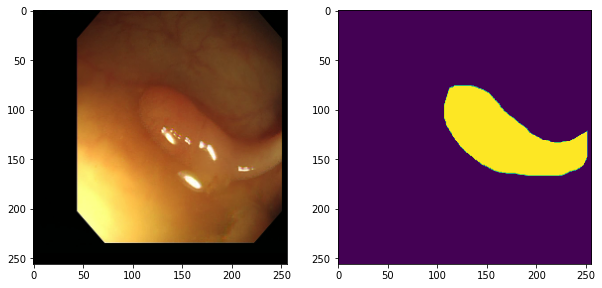

In [15]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

15-4. Build the model
오늘 우리는 두 개의 네트워크를 만들어 보고 성능을 비교해 볼 것입니다. 하나는 Encoder-Decoder 스타일의 네트워크이고, 다른 하나는 U-Net입니다.

Encoder-Decoder architecture
Encoder를 이용해 우리가 가진 Train data를 작은 차원의 공간에 압축하는 방식으로 동작합니다.
Decoder는 Encoder가 압축한 데이터들을 우리가 원하는 label 데이터와 같도록 재생성합니다.
이렇게 생성된 데이터와 label 간의 차이가 작아지도록 Encoder와 Decoder의 파라미터들이 End-to-End로 학습됩니다.

Encoder
input data의 shape가 다음과 같이 되도록 네트워크를 구성합니다.
inputs = [batch_size, 256, 256, 3]
conv1 = [batch_size, 128, 128, 64]
conv2 = [batch_size, 64, 64, 128]
conv3 = [batch_size, 32, 32, 256]
outputs = [batch_size, 16, 16, 512]
Convolution - Normalization - Activation 등의 조합을 다양하게 생각해 봅시다.
Encoder의 차원을 줄여가는 방법으로 Pooling을 쓸지 Convolution with stride=2 로 할지 선택해 볼 수 있습니다.
tf.keras.Sequential()을 이용하여 만들어 봅시다.

Decoder
Encoder의 mirror 형태로 만들어 봅시다.
input data의 shape이 다음과 같이 되도록 네트워크를 구성합니다.
inputs = encoder의 outputs = [batch_size, 16, 16, 512]
conv_transpose1 = [batch_size, 32, 32, 256]
conv_transpose2 = [batch_size, 64, 64, 128]
conv_transpose3 = [batch_size, 128, 128, 64]
outputs = [batch_size, 256, 256, 1]
tf.keras.Sequential()을 이용하여 만들어 봅시다.

In [16]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [17]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


8: 배치 크기 (batch size) 가 8입니다. 즉, encoder 모델에 한 번에 8개의 이미지 데이터가 입력되었습니다.

16: 특징 맵(feature map)의 높이가 16입니다.

16: 특징 맵의 너비가 16입니다.

512: 특징 맵의 채널 수가 512입니다. 즉, 각 픽셀 위치에 512개의 특징이 추출되었습니다.

In [18]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [19]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


Create a encoder-decoder model
지금까지 Encoder와 Decoder를 잘 만들어 왔다면 이 둘을 결합한 모델은 다음과 같이 간단히 구성할 수 있습니다.

In [20]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

U-Net architecture
오늘 우리가 만들어볼 U-Net 모델구조는 아래 그림과 같습니다. 잘 보면 U-Net 원본과는 약간 차이가 있습니다. 논문 원본의 구현에서는 padding을 zero로 하기 때문에 Encoder 레이어 대비 Decoder 레이어에 약간의 사이즈 축소가 발생합니다. 그러나 우리는 padding을 same으로 두고 Encoder, Decoder간 대응하는 레이어의 사이즈를 동일하게 가져갈 것입니다. 이것은 크게 성능에 영향을 주지 않으면서도 구현이 용이할 뿐더러 이후 모델의 추가개선을 더욱 쉽게 만들어 주는 장점이 있습니다.

Model subclassing을 활용한 구현
U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않습니다. 이럴때는 위에 Encoder-Decoder 모델처럼 tf.keras.Sequential()을 쓸 수가 없게 됩니다.

Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API 가 바로 tf.keras functional API 입니다. 오늘 우리는 U-Net 구현을 위해 Model subclassing 방식을 사용하여, tf.keras.Model 클래스를 상속하여 구현할 것입니다.

In [21]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [22]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [23]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

Create a U-Net model
위에서 구현한 Class들을 생성해 최종적으로 U-net 모델을 구현해 줍시다.

In [24]:
unet_model = UNet()

metrics과 loss functions 정의하기
우리가 사용할 loss function은 다음과 같습니다.

binary cross entropy

dice_loss

Image Segmentation Task에서 정답을 더 잘 찾아내기위해 새로운 Loss를 추가해 사용한다.
논문에 나온 Dice coefficient 수식

Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습할 수 있다.

Cross-entropy loss와 Dice loss를 함께 사용하여 mean Intersection over Union (mIoU) 를 높이도록 학습하는 것은 이미지 분할 (Image Segmentation) 작업에서 흔히 사용되는 전략입니다. Loss 함수를 사용하는 이유와 두 Loss 함수를 함께 사용하는 이유를 자세히 설명해 드리겠습니다.

1. Loss 함수의 역할:

모델 학습의 지표: Loss 함수는 모델의 예측 결과와 실제 정답(ground truth) 간의 차이를 수치화하는 함수입니다. 모델이 얼마나 "잘못" 예측했는지를 나타내는 지표라고 할 수 있습니다.

모델 최적화의 방향 제시: 딥러닝 모델은 Loss 함수 값을 최소화하는 방향으로 학습됩니다. 즉, Loss 함수는 모델이 학습해야 할 방향을 제시하는 역할을 합니다.

가중치 업데이트: Loss 함수 값은 모델 내부의 가중치(weights)를 업데이트하는 데 사용됩니다. 경사 하강법(gradient descent)과 같은 최적화 알고리즘은 Loss 함수의 기울기를 계산하여 가중치를 조정하고, Loss 함수 값을 점진적으로 감소시킵니다.

2. Cross-entropy Loss:

정의: 주로 분류(classification) 문제에서 사용되는 Loss 함수입니다. 예측 확률 분포와 실제 확률 분포 간의 차이를 측정합니다.

특징:

각 클래스에 대한 예측 확률을 독립적으로 평가합니다.

예측이 틀린 경우, 즉 실제 클래스에 대한 예측 확률이 낮을수록 Loss 값을 크게 부여합니다.

장점:

구현이 비교적 간단합니다.

다양한 분류 문제에 적용 가능합니다.

단점:

클래스 불균형 문제에 취약할 수 있습니다. 즉, 특정 클래스의 데이터가 다른 클래스에 비해 매우 적은 경우, 해당 클래스에 대한 학습이 제대로 이루어지지 않을 수 있습니다.

이미지 분할 문제에서 영역(region) 기반의 특징을 잘 반영하지 못할 수 있습니다. 즉, 픽셀 단위의 정확도는 높일 수 있지만, 전체적인 영역의 형태나 연결성을 고려하지 못할 수 있습니다.

3. Dice Loss:

정의: 이미지 분할 문제에서 주로 사용되는 Loss 함수입니다. 예측 영역과 실제 영역 간의 Overlap (겹치는 정도) 을 측정합니다.

특징:

두 영역 간의 유사도를 측정하는 Dice coefficient를 기반으로 합니다.

클래스 불균형 문제에 덜 민감합니다. 즉, 특정 클래스의 영역이 다른 클래스에 비해 매우 작은 경우에도 비교적 안정적인 학습이 가능합니다.

전체적인 영역의 형태나 연결성을 고려합니다.

장점:

클래스 불균형 문제에 강합니다.

이미지 분할 성능 향상에 효과적입니다.

단점:

구현이 Cross-entropy Loss보다 복잡할 수 있습니다.

매우 작은 객체에 대해서는 불안정할 수 있습니다.

4. Cross-entropy Loss와 Dice Loss를 함께 사용하는 이유:

상호 보완: Cross-entropy Loss와 Dice Loss는 서로 다른 장단점을 가지고 있습니다. 따라서 두 Loss 함수를 함께 사용하면 서로의 단점을 보완하고, 장점을 극대화할 수 있습니다.

클래스 불균형 문제 완화: Dice Loss는 클래스 불균형 문제에 강하므로, Cross-entropy Loss의 단점을 보완할 수 있습니다.

영역 기반 특징 강화: Dice Loss는 영역 기반의 특징을 잘 반영하므로, 이미지 분할 결과의 전체적인 품질을 향상시킬 수 있습니다.

mIoU 향상: mIoU (mean Intersection over Union) 는 이미지 분할 모델의 성능을 평가하는 지표 중 하나입니다. Cross-entropy Loss와 Dice Loss를 함께 사용하면 mIoU 값을 높이는 데 효과적입니다.

👉Cross-entropy Loss는 픽셀 단위의 정확도에 초점을 맞추는 반면, Dice Loss는 영역(region) 기반의 정확도에 초점을 맞춥니다.

In [25]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

Dice Loss가 최대화되는 방향으로 구해지도록, 아래와 같이 사용합니다.

In [26]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

새로운 Loss function을 사용하기위해서 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성합니다.

In [27]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [28]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

Select a model

👉select the Encoder-Decoder model

In [29]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

print('select the Encoder-Decoder model')
model = ed_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

# print('select the U-Net model')
# model = unet_model
# checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the Encoder-Decoder model


Compile

In [30]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (8, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (8, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


Callbacks
Callback 함수들을 이용하여, 학습 중간에 원하는 동작을 할 수 있도록 합니다.
ModelCheckpoint callback 함수는 모델 학습간 특정 feature를 모니터링하다 기준점을 넘으면 모델 파라미터를 저장하는 역할을 합니다.
LearningRateScheduler callback 함수는 학습을 진행하며, 주어진 인자의 값을 이용해 Learning rate를 조절해주는 함수입니다.
cos_decay는 cos 함수의 모양으로 Learning rate를 조절해 주는 learning rate decay 구현입니다.

In [32]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [33]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

15-5. Train your model
모델 학습 이전에, 모델에서 예측한 이미지를 출력할 수 있는 함수를 미리 작성해 모델 성능 테스트에 사용합니다.

In [34]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

Training - model.fit() 함수 이용
학습을 진행하며, 위에서 구성한 Train dataset과 Test dataset등을 이용해 학습을 진행합니다.
👉학습 데이터의 갯수가 부족하기때문에 Test dataset을 Validation dataset으로 사용할 것입니다.
아래는 model를 학습하는 코드입니다. 10 Epoch만 학습을 진행한 후, 미리 학습된 모델을 불러올 예정입니다.

In [35]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 12s 209ms/step - loss: 1.2837 - dice_loss: 0.7973 - val_loss: 2.9643 - val_dice_loss: 0.8976
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 7s 189ms/step - loss: 1.0523 - dice_loss: 0.7480 - val_loss: 1.4085 - val_dice_loss: 0.8345
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 7s 191ms/step - loss: 0.9911 - dice_loss: 0.7232 - val_loss: 1.0800 - val_dice_loss: 0.7642
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 7s 192ms/step - loss: 0.9633 - dice_loss: 0.7133 - val_loss: 1.9220 - val_di

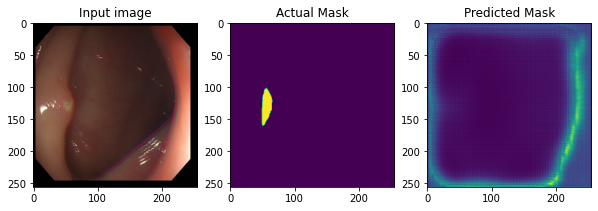

In [36]:
# print sample image after training
print_images()

Plot the loss
저장된 학습 진행과정(history)을 시각화해 봅시다.

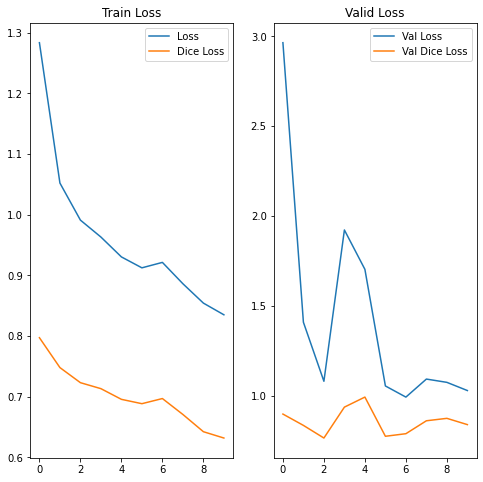

In [37]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

결과 분석)
1. 훈련 손실 (Train Loss) 분석:

Loss (파란색): 훈련 데이터에 대한 손실로, 전반적으로 감소하는 추세를 보입니다. 이는 모델이 훈련 데이터를 학습하고 있다는 것을 의미합니다. 하지만, 감소폭이 점차 줄어드는 것으로 보아 학습이 거의 완료되었거나, 학습률이 너무 낮아 더 이상 학습이 진행되지 않을 가능성이 있습니다.

Dice Loss (주황색): 훈련 데이터에 대한 Dice Loss도 감소하는 추세를 보입니다. Loss보다 낮은 값을 가지며, 감소폭은 크지 않습니다.

2. 검증 손실 (Valid Loss) 분석:

Val Loss (파란색): 검증 데이터에 대한 손실로, 초기에는 급격히 감소하지만, 이후에는 다시 증가하거나 변동이 심한 불안정한 모습을 보입니다. 특히, 2 epoch 이후부터는 loss가 증가와 감소를 반복하며 훈련이 안정적으로 진행되지 못하고 있습니다. 이는 과적합(Overfitting)이 발생했음을 강하게 시사합니다.

Val Dice Loss (주황색): 비교적 안정적인 값을 유지하지만, Val Loss와 마찬가지로 뚜렷한 감소 추세를 보이지 않습니다. Val Loss에 비해 낮은 값을 가지지만, 5 epoch 이후부터는 오히려 증가하는 경향을 보이기도 합니다.

Restore the latest checkpoint
저장된 모델의 가중치를 불러옵니다. ed_ckpt나 unet_ckpt에 담긴 것이 미리 학습시킨 모델입니다. 직접 학습시킨 모델은 train_ckpt에 있습니다. 원하는 모델을 불러와 사용하세요.

In [38]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

Evaluate the test dataset
불러온 가중치를 이용해서 모델을 평가해 봅시다. meanIoU를 metric으로 하여 정량적으로 평가해 볼 수 있고, 실제 생성된 segmentation 이미지를 분석해서 정성적으로 평가해 볼 수 있습니다.

meanIoU란 각 이미지의 IoU 값을 평균 낸 값입니다. IoU는 segmentation 모델을 정량적으로 평가하는데 좋은 metric이 됩니다. 개념은 아래 그림과 같습니다.

In [39]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

테스트 데이터셋을 불러와서 meanIoU 값을 구해 봅시다. 이 값이 우리가 훈련시킨 모델에 대한 정량적 성능 metric이 됩니다.

In [40]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.47781455516815186


Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인해 봅시다.

## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

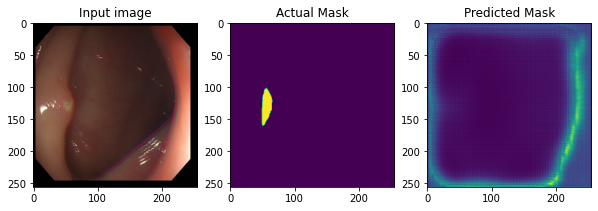

In [41]:
print_images()